In [3]:

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.image import imread
import os
import random
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Dropout,  Flatten, Dense,MaxPool2D
 #for explainable
from skimage.segmentation import mark_boundaries
import lime
from lime import lime_image

C:\Users\yosep\anaconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
data_path = 'Data/'
train_path = 'Data/train/'
test_path = 'Data/test/'
os.listdir(train_path)
     

['COVID19', 'NORMAL']

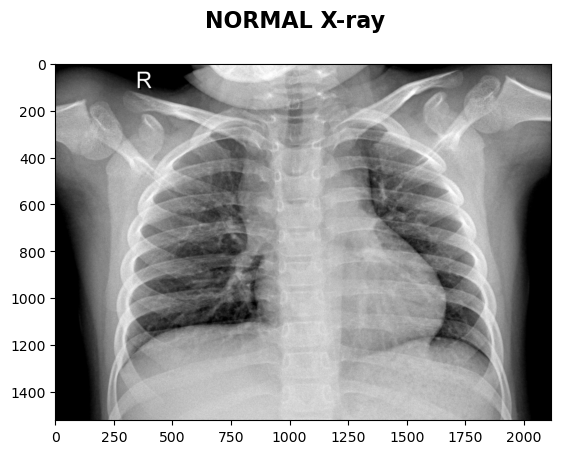

In [5]:

normal_sample = imread(train_path+"/NORMAL"+"/NORMAL(285).jpg")
plt.imshow(normal_sample)
plt.suptitle('NORMAL X-ray', fontsize=16, weight='bold');

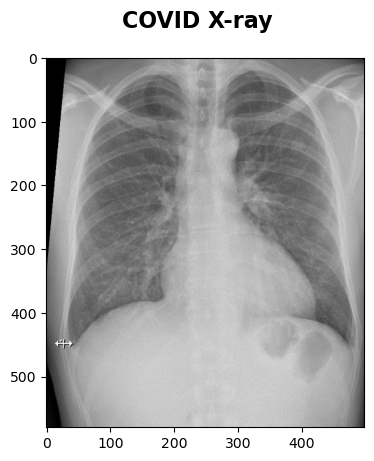

In [6]:
covid_sample = imread(train_path+"/COVID19"+"/COVID19(105).jpg")
plt.imshow(covid_sample)
plt.suptitle('COVID X-ray', fontsize=16, weight='bold');

In [7]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   rotation_range=15,
                                   horizontal_flip = True,
                                  vertical_flip= True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle = False)
     

Found 1736 images belonging to 2 classes.
Found 433 images belonging to 2 classes.


In [9]:


image_size = (224,224,3)

model_1= Sequential()
model_1.add(Conv2D(64,(3,3),activation = "relu", input_shape = image_size))
model_1.add(MaxPool2D())

model_1.add(Conv2D( 128, (3,3), activation = "relu"))
model_1.add(MaxPool2D())


model_1.add(Conv2D( 256,(3,3), activation = "relu"))
model_1.add(MaxPool2D())


model_1.add(Conv2D( 512,(3,3), activation = "relu"))
model_1.add(MaxPool2D())


model_1.add(Flatten())
model_1.add(Dense(512, activation = "relu"))


model_1.add(Dense(2, activation = "softmax"))


model_1.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model_1.summary()
     

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 54, 54, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 256)      

In [9]:
keras.utils.plot_model(model_1,show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [10]:
from datetime import datetime
start=datetime.now()
history_1 = model_1.fit(training_set, validation_data=test_set,steps_per_epoch=54,epochs=50)
end=datetime.now()
print('training time:', end-start)


Epoch 1/50
54/54 [==============================] - 108s 2s/step - loss: 0.5797 - accuracy: 0.7418 - val_loss: 0.3064 - val_accuracy: 0.8152
Epoch 2/50
54/54 [==============================] - 84s 2s/step - loss: 0.4223 - accuracy: 0.8263 - val_loss: 0.3436 - val_accuracy: 0.7945
Epoch 3/50
54/54 [==============================] - 104s 2s/step - loss: 0.2654 - accuracy: 0.9014 - val_loss: 0.1788 - val_accuracy: 0.9284
Epoch 4/50
54/54 [==============================] - 95s 2s/step - loss: 0.2255 - accuracy: 0.9114 - val_loss: 0.0972 - val_accuracy: 0.9492
Epoch 5/50
54/54 [==============================] - 89s 2s/step - loss: 0.1943 - accuracy: 0.9249 - val_loss: 0.2102 - val_accuracy: 0.9145
Epoch 6/50
54/54 [==============================] - 88s 2s/step - loss: 0.1675 - accuracy: 0.9407 - val_loss: 0.2040 - val_accuracy: 0.9099
Epoch 7/50
54/54 [==============================] - 87s 2s/step - loss: 0.1548 - accuracy: 0.9472 - val_loss: 0.0911 - val_accuracy: 0.9630
Epoch 8/50
54/54 [

In [79]:
print("training_accuracy", history_1.history['accuracy'][-1])
print("validation_accuracy", history_1.history['val_accuracy'][-1])

training_accuracy 0.9853286147117615
validation_accuracy 0.9838337302207947


<AxesSubplot:>

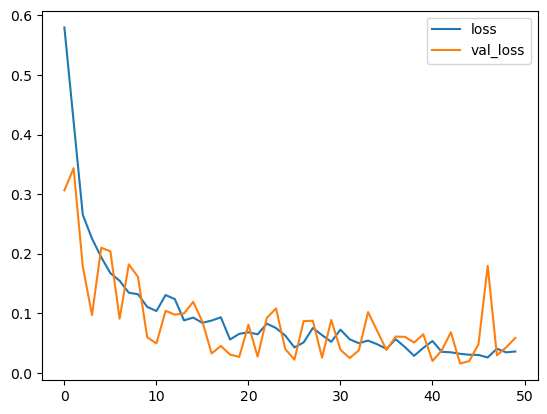

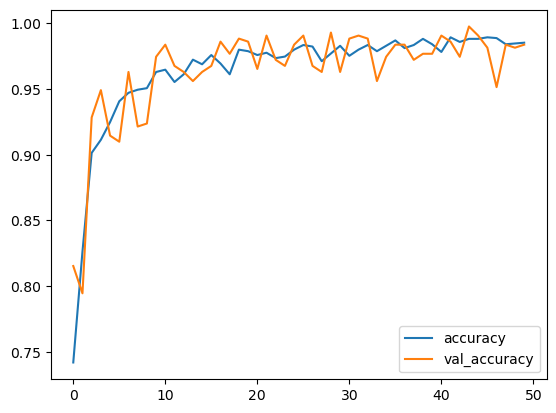

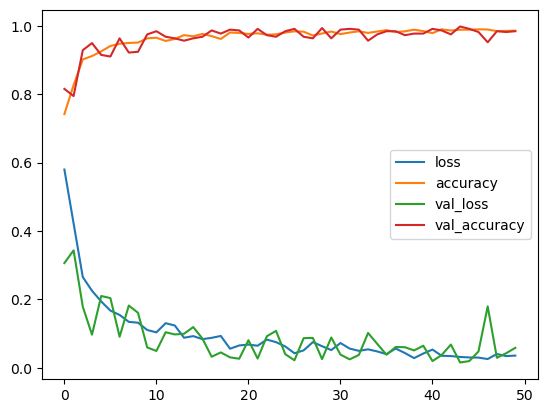

In [80]:
losses = pd.DataFrame(history_1.history)
losses.head()
losses[['loss','val_loss']].plot() 
losses[['accuracy','val_accuracy']].plot() 
losses.plot()

In [13]:
import os
model_version=max([int(i) for i in os.listdir("Saved_Models") + [0]])+1
model_1.save(f"Saved_Models/{model_version}")

INFO:tensorflow:Assets written to: Saved_Models/1\assets


INFO:tensorflow:Assets written to: Saved_Models/1\assets


14/14 [==============================] - 12s 802ms/step


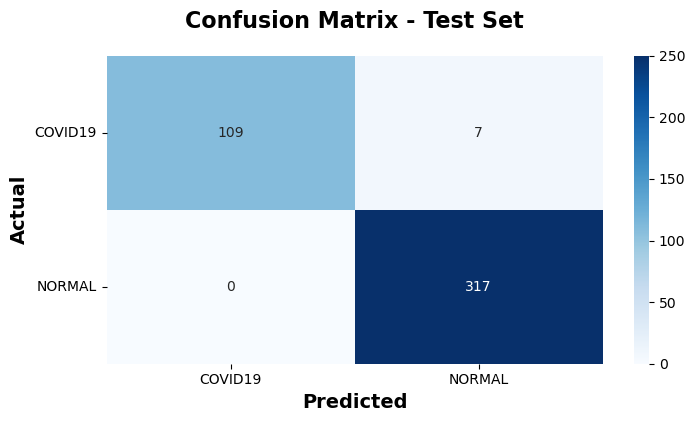

In [31]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


classes = ["COVID19", "NORMAL"]

y_pred = model_1.predict(test_set)
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_set.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(8, 4))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [32]:
print(classification_report(y_true, predictions))


              precision    recall  f1-score   support

           0       1.00      0.94      0.97       116
           1       0.98      1.00      0.99       317

    accuracy                           0.98       433
   macro avg       0.99      0.97      0.98       433
weighted avg       0.98      0.98      0.98       433



In [ ]:
class_dict = {0:'COVID19',
              1:'NORMAL'
              }

In [ ]:
def find_true_class(file_path):
    true_class = None
    if 'COVID19' in file_path:
        true_class = 'COVID19'
    elif 'NORMAL' in file_path:
        true_class = 'NORMAL'
    return true_class

In [ ]:
def visualize(file_path,ax,text_loc):
    test_image = cv2.imread(data_path + file_path)
    test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_NEAREST)
    test_image = np.expand_dims(test_image,axis=0)
    probs = model_1.predict(test_image)
    pred_class = np.argmax(probs)
    pred_class = class_dict[pred_class]
    
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(test_image[0], model_1.predict, top_labels=5, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)


    ax.imshow(mark_boundaries(temp, mask))
    fig.text(text_loc, 0.9, "Predicted Class: " + pred_class , fontsize=13)
    true_class = find_true_class(file_path)
    if true_class is not None:
        fig.text(text_loc, 0.86, "Actual Class: " + true_class , fontsize=13)

1/1 [==============================] - 0s 27ms/step


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▊                                                                               | 10/1000 [00:00<00:15, 64.78it/s]

1/1 [==============================] - 0s 16ms/step


  2%|█▌                                                                              | 20/1000 [00:00<00:14, 65.81it/s]

1/1 [==============================] - 0s 8ms/step


  3%|██▍                                                                             | 30/1000 [00:00<00:14, 65.82it/s]

1/1 [==============================] - 0s 5ms/step


  4%|███▏                                                                            | 40/1000 [00:00<00:15, 61.20it/s]

1/1 [==============================] - 0s 10ms/step


  5%|████                                                                            | 50/1000 [00:00<00:16, 57.49it/s]

1/1 [==============================] - 0s 23ms/step


  6%|████▊                                                                           | 60/1000 [00:01<00:16, 55.72it/s]

1/1 [==============================] - 0s 24ms/step


  7%|█████▌                                                                          | 70/1000 [00:01<00:15, 58.58it/s]

1/1 [==============================] - 0s 20ms/step


  8%|██████▍                                                                         | 80/1000 [00:01<00:15, 61.10it/s]

1/1 [==============================] - 0s 16ms/step


  9%|███████▏                                                                        | 90/1000 [00:01<00:14, 62.86it/s]

1/1 [==============================] - 0s 16ms/step


 10%|███████▉                                                                       | 100/1000 [00:01<00:13, 65.92it/s]

1/1 [==============================] - 0s 21ms/step


 11%|████████▋                                                                      | 110/1000 [00:01<00:13, 65.76it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█████████▍                                                                     | 120/1000 [00:01<00:13, 66.31it/s]

1/1 [==============================] - 0s 21ms/step


 13%|██████████▎                                                                    | 130/1000 [00:02<00:14, 61.25it/s]

1/1 [==============================] - 0s 20ms/step


 14%|███████████                                                                    | 140/1000 [00:02<00:14, 60.31it/s]

1/1 [==============================] - 0s 16ms/step


 15%|███████████▊                                                                   | 150/1000 [00:02<00:14, 58.65it/s]

1/1 [==============================] - 0s 20ms/step


 16%|████████████▋                                                                  | 160/1000 [00:02<00:14, 58.85it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█████████████▍                                                                 | 170/1000 [00:02<00:14, 57.63it/s]

1/1 [==============================] - 0s 21ms/step


 18%|██████████████▏                                                                | 180/1000 [00:02<00:14, 58.06it/s]

1/1 [==============================] - 0s 22ms/step


 19%|███████████████                                                                | 190/1000 [00:03<00:14, 56.73it/s]

1/1 [==============================] - 0s 15ms/step


 20%|███████████████▊                                                               | 200/1000 [00:03<00:14, 56.38it/s]

1/1 [==============================] - 0s 18ms/step


 21%|████████████████▌                                                              | 210/1000 [00:03<00:13, 60.61it/s]

1/1 [==============================] - 0s 18ms/step


 22%|█████████████████▍                                                             | 220/1000 [00:03<00:13, 58.88it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██████████████████▏                                                            | 230/1000 [00:03<00:13, 57.57it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██████████████████▉                                                            | 240/1000 [00:04<00:13, 57.57it/s]

1/1 [==============================] - 0s 16ms/step


 25%|███████████████████▊                                                           | 250/1000 [00:04<00:13, 56.99it/s]

1/1 [==============================] - 0s 21ms/step


 26%|████████████████████▌                                                          | 260/1000 [00:04<00:13, 55.98it/s]

1/1 [==============================] - 0s 13ms/step


 27%|█████████████████████▎                                                         | 270/1000 [00:04<00:12, 56.16it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██████████████████████                                                         | 280/1000 [00:04<00:13, 55.34it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██████████████████████▉                                                        | 290/1000 [00:04<00:12, 55.22it/s]

1/1 [==============================] - 0s 11ms/step


 30%|███████████████████████▋                                                       | 300/1000 [00:05<00:12, 58.26it/s]

1/1 [==============================] - 0s 17ms/step


 31%|████████████████████████▍                                                      | 310/1000 [00:05<00:11, 58.76it/s]

1/1 [==============================] - 0s 16ms/step


 32%|█████████████████████████▎                                                     | 320/1000 [00:05<00:11, 59.21it/s]

1/1 [==============================] - 0s 7ms/step


 33%|██████████████████████████                                                     | 330/1000 [00:05<00:11, 57.55it/s]

1/1 [==============================] - 0s 16ms/step


 34%|██████████████████████████▊                                                    | 340/1000 [00:05<00:11, 56.91it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███████████████████████████▋                                                   | 350/1000 [00:05<00:11, 54.86it/s]

1/1 [==============================] - 0s 22ms/step


 36%|████████████████████████████▍                                                  | 360/1000 [00:06<00:11, 55.87it/s]

1/1 [==============================] - 0s 10ms/step


 37%|█████████████████████████████▏                                                 | 370/1000 [00:06<00:11, 55.70it/s]

1/1 [==============================] - 0s 21ms/step


 38%|██████████████████████████████                                                 | 380/1000 [00:06<00:11, 55.34it/s]

1/1 [==============================] - 0s 19ms/step


 39%|██████████████████████████████▊                                                | 390/1000 [00:06<00:10, 59.36it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████████████████████▌                                               | 400/1000 [00:06<00:10, 59.20it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████████████████████████████████▍                                              | 410/1000 [00:06<00:10, 58.04it/s]

1/1 [==============================] - 0s 21ms/step


 42%|█████████████████████████████████▏                                             | 420/1000 [00:07<00:10, 57.18it/s]

1/1 [==============================] - 0s 21ms/step


 43%|█████████████████████████████████▉                                             | 430/1000 [00:07<00:10, 56.78it/s]

1/1 [==============================] - 0s 16ms/step


 44%|██████████████████████████████████▊                                            | 440/1000 [00:07<00:10, 55.81it/s]

1/1 [==============================] - 0s 20ms/step


 45%|███████████████████████████████████▌                                           | 450/1000 [00:07<00:09, 56.22it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████████████████████████████████████▎                                          | 460/1000 [00:07<00:09, 56.67it/s]

1/1 [==============================] - 0s 6ms/step


 47%|█████████████████████████████████████▏                                         | 470/1000 [00:08<00:09, 56.52it/s]

1/1 [==============================] - 0s 22ms/step


 48%|█████████████████████████████████████▉                                         | 480/1000 [00:08<00:08, 58.91it/s]

1/1 [==============================] - 0s 19ms/step


 49%|██████████████████████████████████████▋                                        | 490/1000 [00:08<00:08, 58.95it/s]

1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████▌                                       | 500/1000 [00:08<00:08, 55.98it/s]

1/1 [==============================] - 0s 20ms/step


 51%|████████████████████████████████████████▎                                      | 510/1000 [00:08<00:08, 55.73it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████████████████████████████████████████                                      | 520/1000 [00:08<00:08, 56.06it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████████████████████████████████████████▊                                     | 530/1000 [00:09<00:08, 56.19it/s]

1/1 [==============================] - 0s 22ms/step


 54%|██████████████████████████████████████████▋                                    | 540/1000 [00:09<00:08, 55.69it/s]

1/1 [==============================] - 0s 20ms/step


 55%|███████████████████████████████████████████▍                                   | 550/1000 [00:09<00:08, 55.56it/s]

1/1 [==============================] - 0s 23ms/step


 56%|████████████████████████████████████████████▏                                  | 560/1000 [00:09<00:07, 55.74it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████████████████████████████████████████████                                  | 570/1000 [00:09<00:07, 59.07it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [00:09<00:06, 62.35it/s]

1/1 [==============================] - 0s 23ms/step


 59%|██████████████████████████████████████████████▌                                | 590/1000 [00:10<00:06, 59.29it/s]

1/1 [==============================] - 0s 22ms/step


 60%|███████████████████████████████████████████████▍                               | 600/1000 [00:10<00:06, 58.11it/s]

1/1 [==============================] - 0s 22ms/step


 61%|████████████████████████████████████████████████▏                              | 610/1000 [00:10<00:06, 56.93it/s]

1/1 [==============================] - 0s 24ms/step


 62%|████████████████████████████████████████████████▉                              | 620/1000 [00:10<00:06, 56.01it/s]

1/1 [==============================] - 0s 21ms/step


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [00:10<00:06, 56.06it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [00:11<00:06, 55.78it/s]

1/1 [==============================] - 0s 22ms/step


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [00:11<00:06, 55.99it/s]

1/1 [==============================] - 0s 22ms/step


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [00:11<00:06, 56.43it/s]

1/1 [==============================] - 0s 20ms/step


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [00:11<00:05, 56.61it/s]

1/1 [==============================] - 0s 15ms/step


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [00:11<00:05, 60.29it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [00:11<00:05, 58.97it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [00:12<00:05, 58.20it/s]

1/1 [==============================] - 0s 26ms/step


 71%|████████████████████████████████████████████████████████                       | 710/1000 [00:12<00:05, 57.58it/s]

1/1 [==============================] - 0s 20ms/step


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [00:12<00:04, 58.99it/s]

1/1 [==============================] - 0s 19ms/step


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [00:12<00:04, 57.76it/s]

1/1 [==============================] - 0s 21ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [00:12<00:04, 57.71it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [00:12<00:04, 57.44it/s]

1/1 [==============================] - 0s 25ms/step


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [00:13<00:04, 56.85it/s]

1/1 [==============================] - 0s 21ms/step


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [00:13<00:04, 57.31it/s]

1/1 [==============================] - 0s 17ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [00:13<00:03, 58.11it/s]

1/1 [==============================] - 0s 16ms/step


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [00:13<00:03, 58.78it/s]

1/1 [==============================] - 0s 12ms/step


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [00:13<00:03, 59.07it/s]

1/1 [==============================] - 0s 9ms/step


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [00:13<00:03, 57.73it/s]

1/1 [==============================] - 0s 7ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [00:14<00:03, 58.16it/s]

1/1 [==============================] - 0s 21ms/step


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [00:14<00:02, 57.95it/s]

1/1 [==============================] - 0s 21ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [00:14<00:02, 57.61it/s]

1/1 [==============================] - 0s 17ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [00:14<00:02, 60.10it/s]

1/1 [==============================] - 0s 8ms/step


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [00:14<00:02, 62.86it/s]

1/1 [==============================] - 0s 14ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [00:14<00:01, 67.07it/s]

1/1 [==============================] - 0s 19ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [00:15<00:01, 64.96it/s]

1/1 [==============================] - 0s 24ms/step


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [00:15<00:01, 61.07it/s]

1/1 [==============================] - 0s 21ms/step


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [00:15<00:01, 59.63it/s]

1/1 [==============================] - 0s 22ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [00:15<00:01, 59.45it/s]

1/1 [==============================] - 0s 21ms/step


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [00:15<00:01, 58.64it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [00:15<00:01, 58.69it/s]

1/1 [==============================] - 0s 20ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [00:16<00:00, 60.31it/s]

1/1 [==============================] - 0s 20ms/step


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [00:16<00:00, 60.43it/s]

1/1 [==============================] - 0s 22ms/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [00:16<00:00, 60.30it/s]

1/1 [==============================] - 0s 20ms/step


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [00:16<00:00, 58.97it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [00:16<00:00, 58.41it/s]

1/1 [==============================] - 0s 21ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [00:16<00:00, 58.53it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 58.35it/s]


1/1 [==============================] - 0s 19ms/step


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▊                                                                               | 10/1000 [00:00<00:16, 61.72it/s]

1/1 [==============================] - 0s 21ms/step


  2%|█▌                                                                              | 20/1000 [00:00<00:16, 60.84it/s]

1/1 [==============================] - 0s 22ms/step


  3%|██▍                                                                             | 30/1000 [00:00<00:15, 62.48it/s]

1/1 [==============================] - 0s 8ms/step


  4%|███▏                                                                            | 40/1000 [00:00<00:15, 60.57it/s]

1/1 [==============================] - 0s 20ms/step


  5%|████                                                                            | 50/1000 [00:00<00:14, 66.38it/s]

1/1 [==============================] - 0s 21ms/step


  6%|████▊                                                                           | 60/1000 [00:00<00:14, 63.23it/s]

1/1 [==============================] - 0s 20ms/step


  7%|█████▌                                                                          | 70/1000 [00:01<00:14, 62.77it/s]

1/1 [==============================] - 0s 22ms/step


  8%|██████▍                                                                         | 80/1000 [00:01<00:15, 60.19it/s]

1/1 [==============================] - 0s 22ms/step


  9%|███████▏                                                                        | 90/1000 [00:01<00:15, 59.26it/s]

1/1 [==============================] - 0s 21ms/step


 10%|███████▉                                                                       | 100/1000 [00:01<00:15, 59.02it/s]

1/1 [==============================] - 0s 21ms/step


 11%|████████▋                                                                      | 110/1000 [00:01<00:14, 60.17it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█████████▍                                                                     | 120/1000 [00:01<00:14, 60.33it/s]

1/1 [==============================] - 0s 21ms/step


 13%|██████████▎                                                                    | 130/1000 [00:02<00:14, 60.82it/s]

1/1 [==============================] - 0s 22ms/step


 14%|███████████                                                                    | 140/1000 [00:02<00:13, 63.68it/s]

1/1 [==============================] - 0s 14ms/step


 15%|███████████▊                                                                   | 150/1000 [00:02<00:13, 62.67it/s]

1/1 [==============================] - 0s 21ms/step


 16%|████████████▋                                                                  | 160/1000 [00:02<00:13, 61.86it/s]

1/1 [==============================] - 0s 11ms/step


 17%|█████████████▍                                                                 | 170/1000 [00:02<00:13, 60.08it/s]

1/1 [==============================] - 0s 21ms/step


 18%|██████████████▏                                                                | 180/1000 [00:02<00:13, 59.49it/s]

1/1 [==============================] - 0s 20ms/step


 19%|███████████████                                                                | 190/1000 [00:03<00:13, 61.27it/s]

1/1 [==============================] - 0s 9ms/step


 20%|███████████████▊                                                               | 200/1000 [00:03<00:13, 60.90it/s]

1/1 [==============================] - 0s 21ms/step


 21%|████████████████▌                                                              | 210/1000 [00:03<00:13, 60.73it/s]

1/1 [==============================] - 0s 21ms/step


 22%|█████████████████▍                                                             | 220/1000 [00:03<00:12, 60.80it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██████████████████▏                                                            | 230/1000 [00:03<00:11, 65.27it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██████████████████▉                                                            | 240/1000 [00:03<00:11, 66.87it/s]

1/1 [==============================] - 0s 21ms/step


 25%|███████████████████▊                                                           | 250/1000 [00:04<00:11, 62.54it/s]

1/1 [==============================] - 0s 19ms/step


 26%|████████████████████▌                                                          | 260/1000 [00:04<00:11, 63.52it/s]

1/1 [==============================] - 0s 21ms/step


 27%|█████████████████████▎                                                         | 270/1000 [00:04<00:11, 65.05it/s]

1/1 [==============================] - 0s 9ms/step


 28%|██████████████████████                                                         | 280/1000 [00:04<00:11, 63.75it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██████████████████████▉                                                        | 290/1000 [00:04<00:11, 61.39it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███████████████████████▋                                                       | 300/1000 [00:04<00:11, 61.54it/s]

1/1 [==============================] - 0s 18ms/step


 31%|████████████████████████▍                                                      | 310/1000 [00:04<00:10, 62.83it/s]

1/1 [==============================] - 0s 9ms/step


 32%|█████████████████████████▎                                                     | 320/1000 [00:05<00:10, 61.92it/s]

1/1 [==============================] - 0s 16ms/step


 33%|██████████████████████████                                                     | 330/1000 [00:05<00:10, 63.26it/s]

1/1 [==============================] - 0s 19ms/step


 34%|██████████████████████████▊                                                    | 340/1000 [00:05<00:10, 60.38it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███████████████████████████▋                                                   | 350/1000 [00:05<00:10, 62.16it/s]

1/1 [==============================] - 0s 20ms/step


 36%|████████████████████████████▍                                                  | 360/1000 [00:05<00:10, 63.54it/s]

1/1 [==============================] - 0s 24ms/step


 37%|█████████████████████████████▏                                                 | 370/1000 [00:05<00:10, 62.32it/s]

1/1 [==============================] - 0s 16ms/step


 38%|██████████████████████████████                                                 | 380/1000 [00:06<00:10, 61.55it/s]

1/1 [==============================] - 0s 21ms/step


 39%|██████████████████████████████▊                                                | 390/1000 [00:06<00:10, 60.49it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████████████████████▌                                               | 400/1000 [00:06<00:09, 60.96it/s]

1/1 [==============================] - 0s 5ms/step


 41%|████████████████████████████████▍                                              | 410/1000 [00:06<00:09, 60.88it/s]

1/1 [==============================] - 0s 18ms/step


 42%|█████████████████████████████████▏                                             | 420/1000 [00:06<00:08, 65.11it/s]

1/1 [==============================] - 0s 10ms/step


 43%|█████████████████████████████████▉                                             | 430/1000 [00:06<00:08, 68.44it/s]

1/1 [==============================] - 0s 16ms/step


 44%|██████████████████████████████████▊                                            | 440/1000 [00:07<00:08, 63.34it/s]

1/1 [==============================] - 0s 20ms/step


 45%|███████████████████████████████████▌                                           | 450/1000 [00:07<00:08, 63.27it/s]

1/1 [==============================] - 0s 9ms/step


 46%|████████████████████████████████████▎                                          | 460/1000 [00:07<00:08, 64.96it/s]

1/1 [==============================] - 0s 22ms/step


 47%|█████████████████████████████████████▏                                         | 470/1000 [00:07<00:07, 67.22it/s]

1/1 [==============================] - 0s 14ms/step


 48%|█████████████████████████████████████▉                                         | 480/1000 [00:07<00:08, 64.74it/s]

1/1 [==============================] - 0s 18ms/step


 49%|██████████████████████████████████████▋                                        | 490/1000 [00:07<00:08, 63.17it/s]

1/1 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▌                                       | 500/1000 [00:08<00:07, 62.99it/s]

1/1 [==============================] - 0s 20ms/step


 51%|████████████████████████████████████████▎                                      | 510/1000 [00:08<00:07, 63.20it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████████████████████████████████████████                                      | 520/1000 [00:08<00:07, 62.50it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████████████████████████████████████████▊                                     | 530/1000 [00:08<00:07, 66.23it/s]

1/1 [==============================] - 0s 31ms/step


 54%|██████████████████████████████████████████▋                                    | 540/1000 [00:08<00:07, 65.30it/s]

1/1 [==============================] - 0s 19ms/step


 55%|███████████████████████████████████████████▍                                   | 550/1000 [00:08<00:07, 61.74it/s]

1/1 [==============================] - 0s 20ms/step


 56%|████████████████████████████████████████████▏                                  | 560/1000 [00:08<00:06, 65.46it/s]

1/1 [==============================] - 0s 6ms/step


 57%|█████████████████████████████████████████████                                  | 570/1000 [00:09<00:06, 68.40it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [00:09<00:06, 67.11it/s]

1/1 [==============================] - 0s 7ms/step


 59%|██████████████████████████████████████████████▌                                | 590/1000 [00:09<00:06, 63.62it/s]

1/1 [==============================] - 0s 24ms/step


 60%|███████████████████████████████████████████████▍                               | 600/1000 [00:09<00:06, 63.86it/s]

1/1 [==============================] - 0s 16ms/step


 61%|████████████████████████████████████████████████▏                              | 610/1000 [00:09<00:06, 62.49it/s]

1/1 [==============================] - 0s 21ms/step


 62%|████████████████████████████████████████████████▉                              | 620/1000 [00:09<00:06, 61.79it/s]

1/1 [==============================] - 0s 19ms/step


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [00:10<00:06, 60.02it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [00:10<00:05, 61.23it/s]

1/1 [==============================] - 0s 18ms/step


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [00:10<00:05, 62.80it/s]

1/1 [==============================] - 0s 9ms/step


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [00:10<00:05, 65.47it/s]

1/1 [==============================] - 0s 9ms/step


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [00:10<00:04, 68.12it/s]

1/1 [==============================] - 0s 14ms/step


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [00:10<00:04, 66.52it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [00:10<00:04, 65.96it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [00:11<00:04, 62.48it/s]

1/1 [==============================] - 0s 6ms/step


 71%|████████████████████████████████████████████████████████                       | 710/1000 [00:11<00:04, 66.43it/s]

1/1 [==============================] - 0s 21ms/step


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [00:11<00:04, 69.95it/s]

1/1 [==============================] - 0s 20ms/step


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [00:11<00:04, 66.86it/s]

1/1 [==============================] - 0s 7ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [00:11<00:03, 65.45it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [00:11<00:03, 64.61it/s]

1/1 [==============================] - 0s 21ms/step


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [00:11<00:03, 68.16it/s]

1/1 [==============================] - 0s 21ms/step


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [00:12<00:03, 71.88it/s]

1/1 [==============================] - 0s 22ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [00:12<00:03, 72.28it/s]

1/1 [==============================] - 0s 16ms/step


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [00:12<00:03, 68.60it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [00:12<00:03, 64.82it/s]

1/1 [==============================] - 0s 21ms/step


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [00:12<00:02, 63.60it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [00:12<00:02, 63.12it/s]

1/1 [==============================] - 0s 21ms/step


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [00:13<00:02, 61.34it/s]

1/1 [==============================] - 0s 8ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [00:13<00:02, 61.85it/s]

1/1 [==============================] - 0s 10ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [00:13<00:02, 60.61it/s]

1/1 [==============================] - 0s 20ms/step


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [00:13<00:02, 64.73it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [00:13<00:01, 67.60it/s]

1/1 [==============================] - 0s 20ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [00:13<00:01, 70.24it/s]

1/1 [==============================] - 0s 22ms/step


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [00:13<00:01, 67.44it/s]

1/1 [==============================] - 0s 19ms/step


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [00:14<00:01, 70.47it/s]

1/1 [==============================] - 0s 20ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [00:14<00:01, 71.82it/s]

1/1 [==============================] - 0s 19ms/step


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [00:14<00:01, 68.15it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [00:14<00:01, 63.88it/s]

1/1 [==============================] - 0s 23ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [00:14<00:00, 62.63it/s]

1/1 [==============================] - 0s 7ms/step


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [00:14<00:00, 63.28it/s]

1/1 [==============================] - 0s 17ms/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [00:15<00:00, 67.28it/s]

1/1 [==============================] - 0s 21ms/step


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [00:15<00:00, 70.63it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [00:15<00:00, 72.79it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [00:15<00:00, 73.30it/s]

1/1 [==============================] - 0s 23ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 64.17it/s]


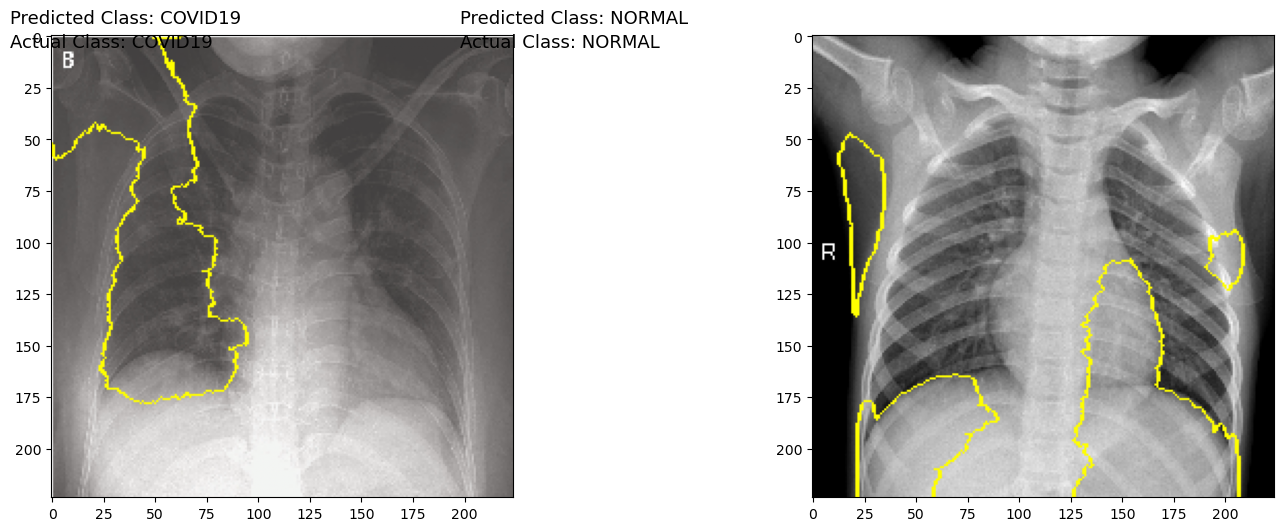

In [93]:
fig,ax = plt.subplots(1,2,figsize=(18,6))
visualize('test/COVID19/COVID19(538).jpg',ax[0],0.15)
visualize('test/NORMAL/NORMAL(1440).jpg',ax[1],0.4)
